In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_relative_footsteps_acc
%store -r Y_relative_footsteps_acc
print(X_relative_footsteps_acc.shape)
print(Y_relative_footsteps_acc.shape)

(8103, 28)
(8103, 8)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_relative_footsteps_acc[:, 24] == 1)[0]
X_relative_footsteps_acc_RR_swing = X_relative_footsteps_acc[idxs]
Y_relative_footsteps_acc_RR_swing = Y_relative_footsteps_acc[idxs]

## Predict FL foot -> x

In [8]:
X_relative_footsteps_acc_RR_swing[0, :]

array([ 0.        ,  0.        , -0.1       ,  0.03223521, -0.16707049,
        0.01633024, -0.05086472,  0.01613139, -0.08244775,  0.22421836,
        0.2146329 , -0.40479645,  0.23125328, -0.18591964, -0.40580276,
       -0.2571617 ,  0.15356685, -0.40042184, -0.2596469 , -0.13334387,
       -0.40039383,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ])

In [9]:
Y_relative_footsteps_acc_RR_swing[0, :]

array([ 0.22407743,  0.18885393,  0.23964177, -0.19926585, -0.26746292,
        0.12131841, -0.25399354, -0.15574807])

### Linear Regression

In [20]:
# Input
X = np.hstack((X_relative_footsteps_acc_RR_swing[:, :3], # prev velocity command
               X_relative_footsteps_acc_RR_swing[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_RR_swing[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_RR_swing[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_RR_swing[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_RR_swing[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_RR_swing[:, 6]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9503717957955482
RMSE:  0.005694691913039429
The lowest error is:  1.5827555109038105e-06
The highest error is:  0.04178109067422345
The avg. error is:  0.003149729249311097


In [21]:
model_rr_relative_swinging_x.coef_

array([[-2.36824220e-02,  1.74989463e-02, -5.00957812e-02,
         1.07963817e-01,  1.49070318e-04, -1.44309833e-02,
         1.30939471e-01, -3.23235768e-02, -1.43906887e-01,
         4.25938702e-02,  4.66137285e-01, -2.09098106e-01,
         2.39600154e-01, -4.18026232e-02]])

In [22]:
model_rr_relative_swinging_x.intercept_

array([-0.02977327])

Text(0, 0.5, 'Predictions')

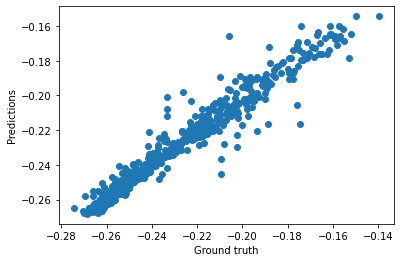

In [23]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [24]:
#%store model_rr_relative_swinging_x

In [25]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [26]:
# Save model
#joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

### Predict RR foot -> y

In [34]:
# Input
X = np.hstack((X_relative_footsteps_acc_RR_swing[:, :3], # prev velocity command
               X_relative_footsteps_acc_RR_swing[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_RR_swing[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_RR_swing[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_RR_swing[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_RR_swing[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_RR_swing[:, 7]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9441901911267876
RMSE:  0.005270114245161632
The lowest error is:  2.3343227158467705e-06
The highest error is:  0.04073599109685455
The avg. error is:  0.0028920525111752853


In [35]:
model_rr_relative_swinging_y.coef_

array([[ 0.00472366, -0.00586961, -0.0036153 , -0.00065418,  0.10493878,
        -0.03870301,  0.06425996, -0.02613534, -0.0974414 ,  0.14293829,
         0.07774154,  0.08868879, -0.02575887,  0.56707569]])

In [36]:
model_rr_relative_swinging_y.intercept_

array([-0.04027396])

Text(0, 0.5, 'Predictions')

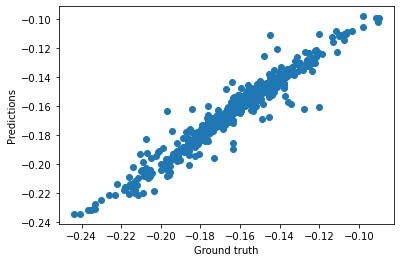

In [37]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [38]:
#%store model_rr_relative_swinging_y

In [30]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [31]:
# Save model
#joblib.dump(model_rr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_y.sav")